In [16]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from matplotlib import cm
from root_pandas import read_root
import scipy.stats
from matplotlib import gridspec
import matplotlib.lines as mlines
import ROOT
import scipy.stats
from matplotlib import gridspec
import matplotlib.lines as mlines
from scipy.stats import chi2
from scipy import interpolate
import pandas as pd

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

def getArrays(tree):

    chi2_c = np.zeros(tree.GetEntries())
    dm2_c = np.zeros(tree.GetEntries())
    sin22th_c = np.zeros(tree.GetEntries())
    
    for j in range(tree.GetEntries()):
        tree.GetEntry(j)
        
        chi2_c[j] = tree.chi2
        dm2_c[j] = tree.dm2
        sin22th_c[j] = tree.sin22th
        
    chi2 = chi2_c[chi2_c>0]
    dm2 = dm2_c[chi2_c>0]
    sin22th = sin22th_c[chi2_c>0]
    return chi2, dm2, sin22th

def getContour(sin22th,dm2):

    adm2 = np.asarray(dm2)
    asin22th = np.asarray(sin22th)

    sin22th_l = np.zeros(len(np.unique(adm2)))
    dm2_l = np.zeros(len(np.unique(adm2)))
   
    
    for i in range(len(np.unique(adm2))):
        indmin = np.argmin(asin22th[adm2==adm2[i]])
        indmax = np.argmax(asin22th[adm2==adm2[i]])
        if asin22th[adm2==adm2[i]][indmax]==asin22th.max() and asin22th[adm2==adm2[i]][0]==asin22th.min() and indmax < 100:
            return None
        sin22th_l[i] = asin22th[adm2==np.unique(adm2)[i]][indmin]
        dm2_l[i] = np.unique(adm2)[i]
    else:
        return sin22th_l, dm2_l

def getContourt(tree):

    dm2 = np.zeros(tree.GetEntries())
    sin22th = np.zeros(tree.GetEntries())
    
    for j in range(tree.GetEntries()):
        tree.GetEntry(j)
        
        dm2[j] = tree.dm2
        sin22th[j] = tree.sin22th
    
    adm2 = np.asarray(dm2)
    asin22th = np.asarray(sin22th)


    cosin22th = np.zeros(len(np.unique(adm2)))
    codm2 = np.zeros(len(np.unique(adm2)))

    for i in range(len(np.unique(adm2))):
        indy = np.argmin(asin22th[adm2==adm2[i]])
        cosin22th[i] = asin22th[adm2==np.unique(adm2)[i]][indy]
        codm2[i] = np.unique(adm2)[i]    
    
    return cosin22th, codm2

In [17]:
# Load Our Fake Data List
f_coords = np.genfromtxt('../build/fakedata_coords_may14.txt')
sin22th_sr = f_coords[:,0]
dm2_sr = f_coords[:,1]
f_chi2 = np.genfromtxt('../build/fakedata_chi2_s_0.8_d_2.0.txt')[1:]

In [18]:
# Load our frequentist correction list
f_chi_sr = np.genfromtxt('../data/uboone/chilist_shaperate_apr20.txt')[:,1:]
f_coord_sr = np.genfromtxt('../data/uboone/coordlist_shaperate_apr20.txt')
a_dm2_sr = f_coord_sr[:,2]
a_sin22th_sr = f_coord_sr[:,1]

mindex_90_sr = int(np.floor((.9)*len(f_chi_sr[0])))
chieff_90_sr = []

for chil in f_chi_sr:
    el90 = np.partition(chil,mindex_90_sr)[mindex_90_sr]
    chieff_90_sr.append(el90)

# load up critical chi2 at each point using interpolation
g90_sr = interpolate.griddata((a_sin22th_sr,a_dm2_sr),chieff_90_sr,(sin22th_sr,dm2_sr),method='linear')

In [19]:
print(a_dm2_sr[0],a_dm2_sr[-1])
print(dm2_sr[0],dm2_sr[-1])

len(np.isnan(g90_sr)[np.isnan(g90_sr)==False])

0.0120226 83.1764
0.01 91.2011


9409

In [20]:
chisqclean = g90_sr[g90_sr==g90_sr]
len(chisqclean)
chisqclean[0]

1.91422

# Question 1:
## In how many pseudoexperiments do we reject the null @ 90%

In [39]:
# Get list of universes which form contours (ie which reject the null hypothesis at 90%)
chisqclean = g90_sr[g90_sr==g90_sr]

nulex_ct = 0
for i in range(len(f_chi2)):#for each pseudoexperiment
   
    if f_chi2[i][0]-f_chi2[i].min() > chisqclean[0]:
        nulex_ct += 1

print(nulex_ct/1000.0)

1.0


In [21]:
# Bring in our sensitivity (limit against null mc)

f = ROOT.TFile("../apr28freqtest/ubsens_sr_proc_v1.root")
tchi_cv = f.Get("numudis_chiogram")
a_chi2_cv, a_dm2_cv, a_sin22th_cv = getArrays(tchi_cv)

g90_cv = interpolate.griddata((a_sin22th_sr,a_dm2_sr),chieff_90_sr,(a_sin22th_cv,a_dm2_cv),method='linear')
tsin22th = a_sin22th_cv[a_chi2_cv>a_chi2_cv.min()+g90_cv]
tdm2 = a_dm2_cv[a_chi2_cv>a_chi2_cv.min()+g90_cv]
ln_90_sin22th_cv,ln_90_dm2_cv = getContour(tsin22th,tdm2)

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [22]:
# Get list of universes which form contours (ie which reject the null hypothesis at 90%)
excluded = np.zeros(len(f_chi2))

for i in range(len(f_chi2)):#check for closed contours
    tsin22th = sin22th_sr[f_chi2[i]>f_chi2.min(axis=1)[i]+g90_sr]
    tdm2 = dm2_sr[f_chi2[i]>f_chi2.min(axis=1)[i]+g90_sr]
    dummy = getContour(tsin22th,tdm2)
    if dummy!=None:
        excluded[i] = 1

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


# Splatter Plot

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less
  
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app


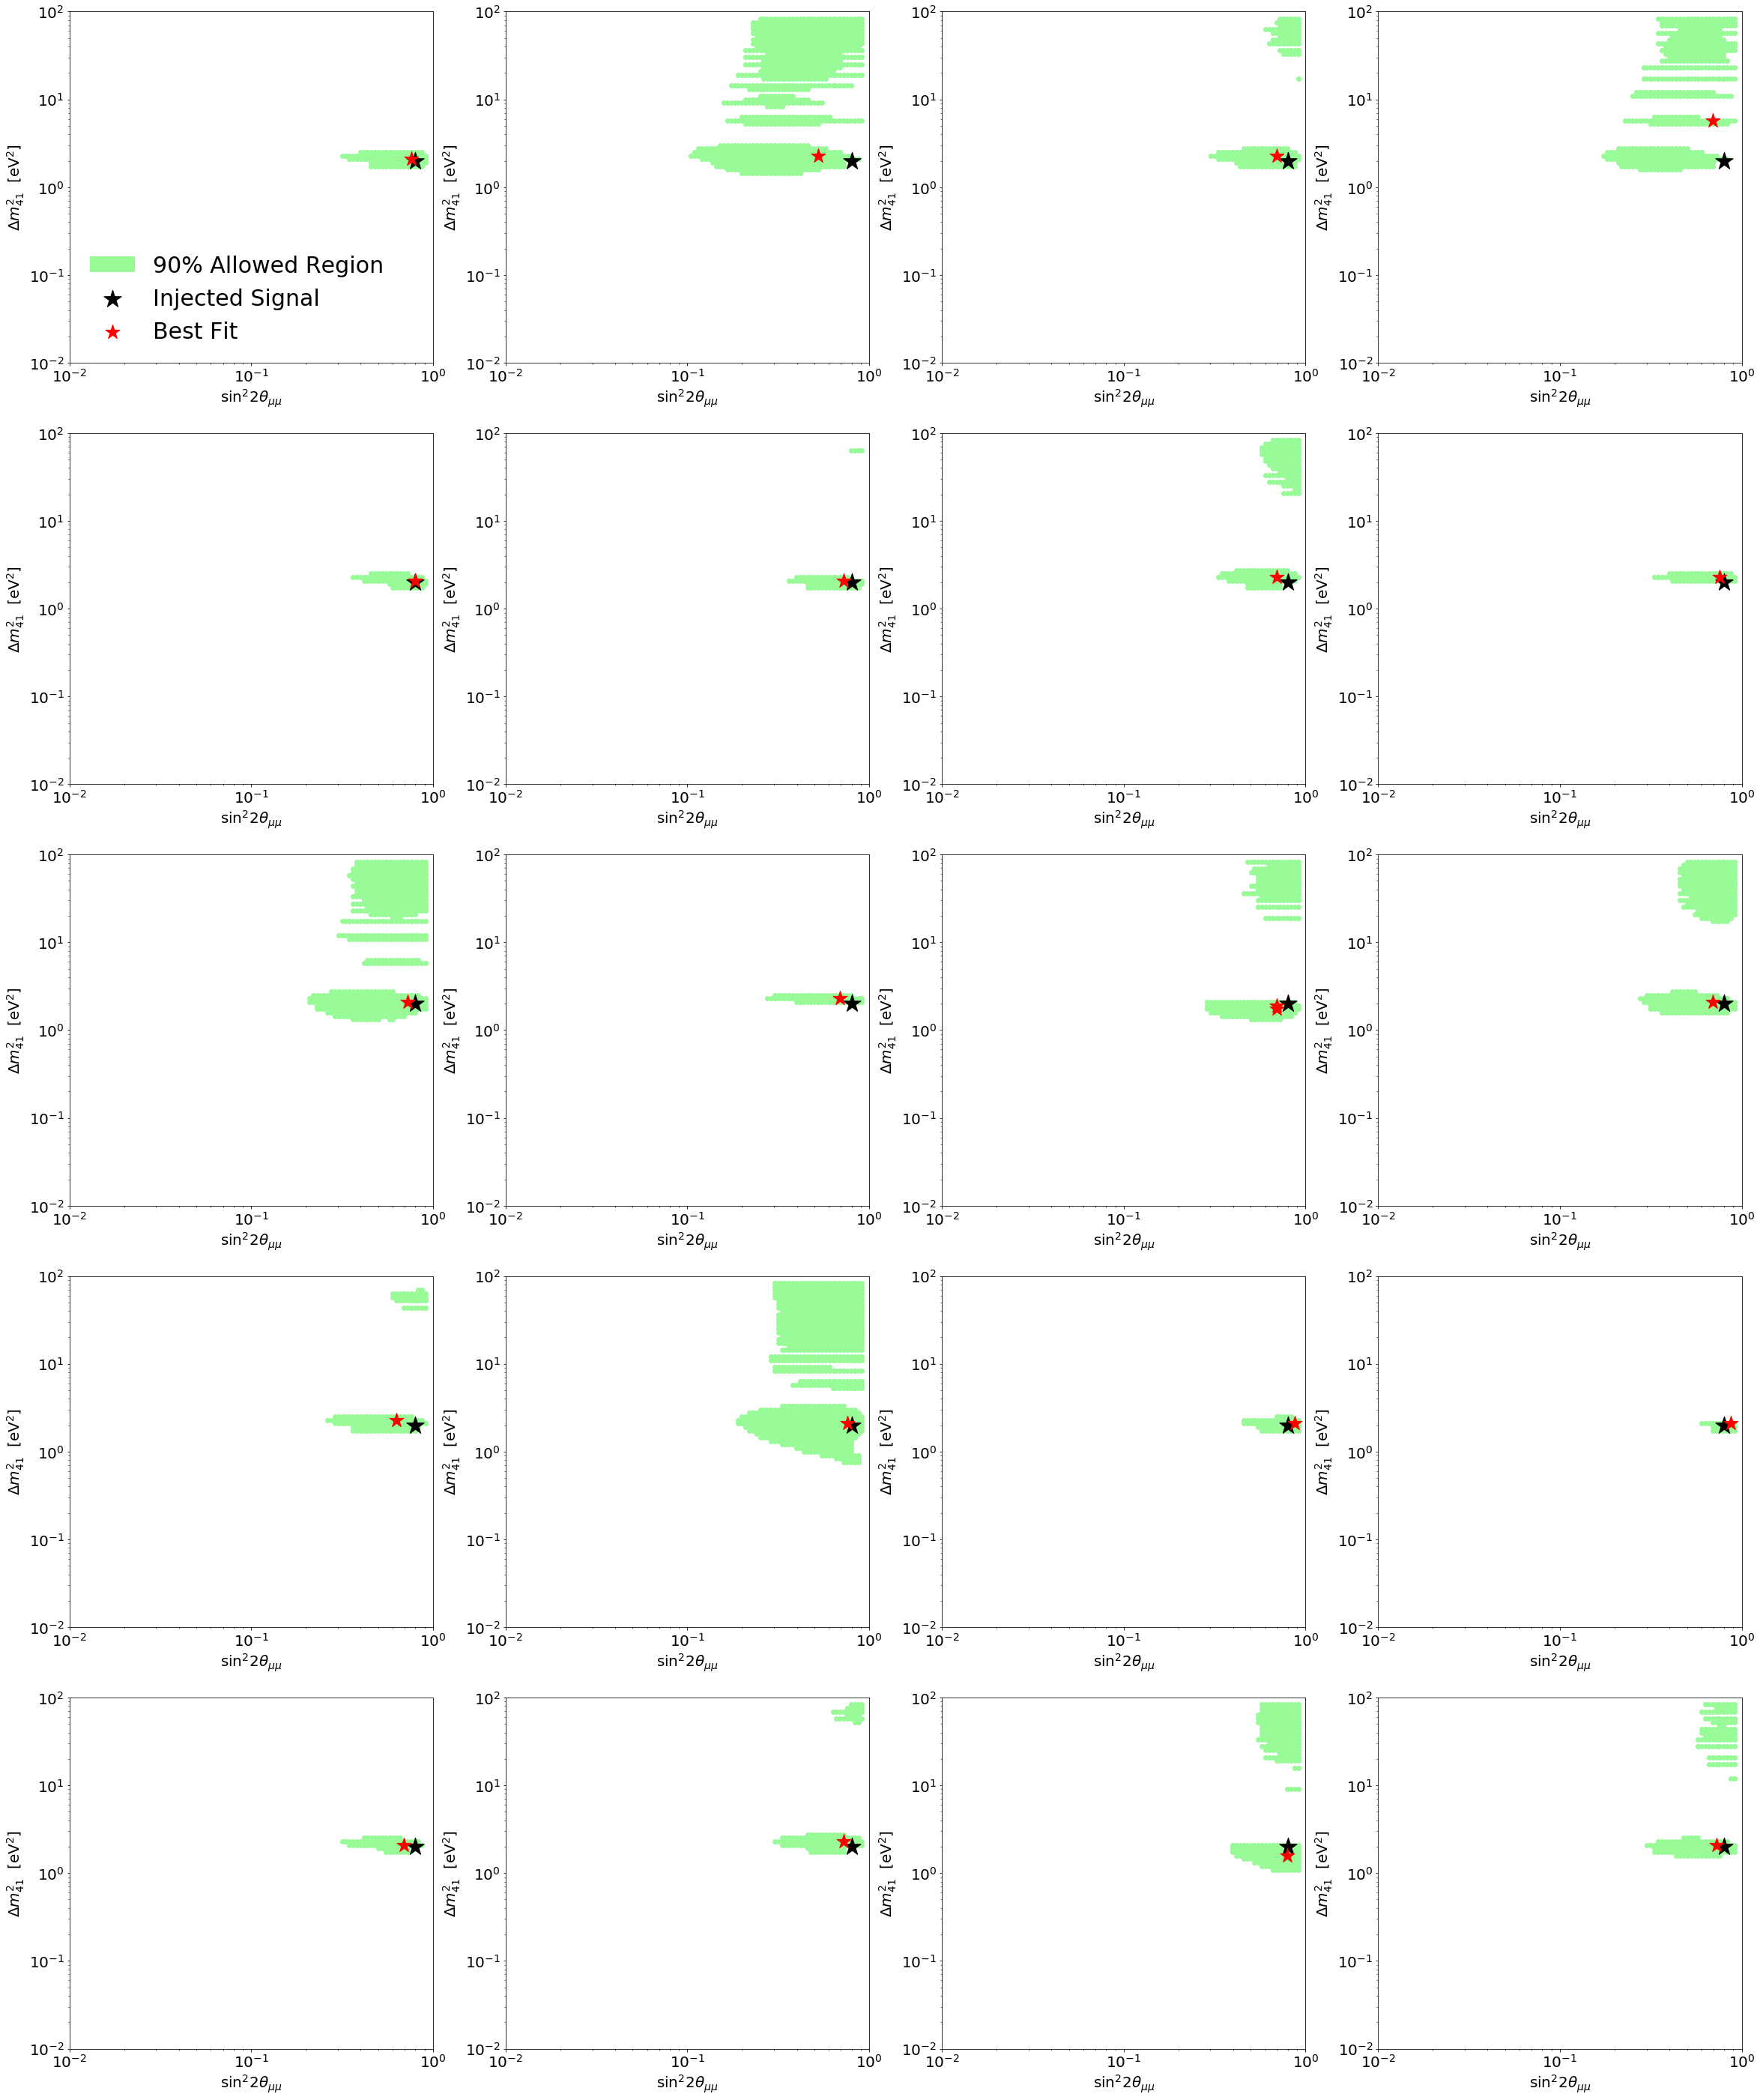

In [37]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(40,50))
axes = axes.flatten()

titlesize = 30
labelsize = 20

for i,ax in enumerate(axes):
    ax.set_xscale("log", nonposx='clip')
    ax.set_yscale("log", nonposy='clip')
    plt.axes(ax)
    plt.xlim(0.01,1)
    plt.ylim(0.01,100)
    
    tsin22th = sin22th_sr[f_chi2[i,:]<f_chi2.min(axis=1)[i]+g90_sr]
    tdm2 = dm2_sr[f_chi2[i]<f_chi2.min(axis=1)[i]+g90_sr]
    plt.scatter(tsin22th,tdm2,color='palegreen')
    
    _ = plt.hist([-1],bins=1,facecolor='palegreen',edgecolor='None',label='90% Allowed Region')
    sin22th_bf = sin22th_sr[f_chi2[i,:]==f_chi2.min(axis=1)[i]]
    dm2_bf = dm2_sr[f_chi2[i,:]==f_chi2.min(axis=1)[i]]
    plt.scatter([.8],[2],marker='*',s=600,zorder=10,c='black',label='Injected Signal')
    plt.scatter([sin22th_bf],[dm2_bf],marker='*',s=400,zorder=10,c='red',label='Best Fit')
    if i==0:
        ax.legend(loc='lower left',fontsize=titlesize,frameon=False)
    
    ax.set_ylabel(r'$\Delta m_{41}^2$  [eV$^2$]',fontsize=labelsize)
    ax.set_xlabel(r'$\sin^2 2 \theta_{\mu \mu}$',fontsize=labelsize)
    plt.xticks(fontsize=labelsize)
    plt.yticks(fontsize=labelsize)
    


/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
No handles with labels found to put in legend.


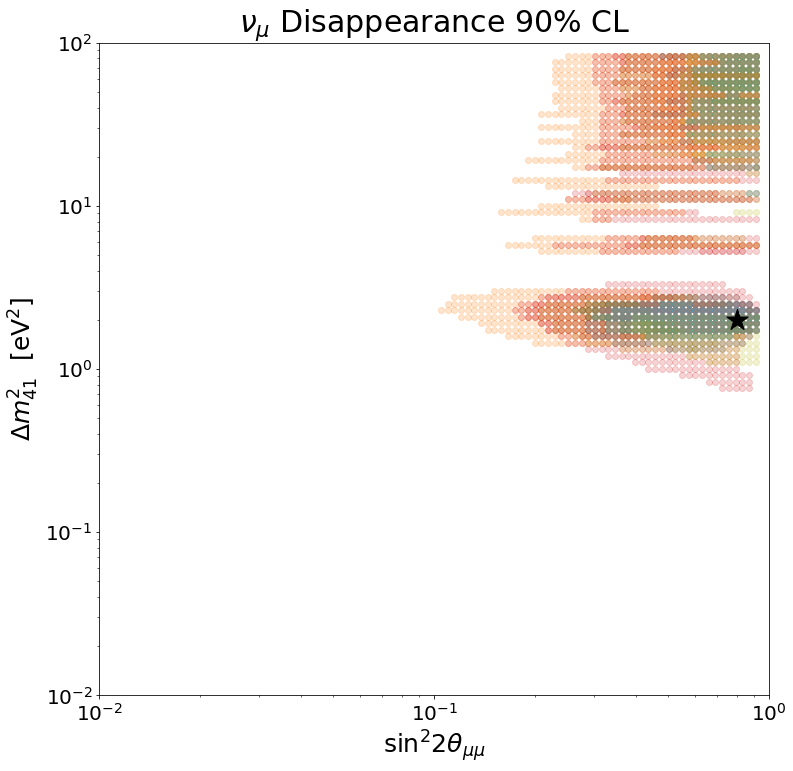

In [7]:
# splatter plot

fig, ax = plt.subplots(figsize=(12,12))
msize=15

for i in range(20):
    if excluded[i]:
        continue
    tsin22th = sin22th_sr[f_chi2[i,:]<f_chi2.min(axis=1)[i]+g90_sr]
    tdm2 = dm2_sr[f_chi2[i]<f_chi2.min(axis=1)[i]+g90_sr]
    plt.scatter(tsin22th,tdm2,alpha=.2)

#plt.annotate('Frequentist Corrected',xy=(0.02, .28), xycoords='axes fraction',fontsize=35)
ax.set_title(r'$\nu_\mu$ Disappearance 90% CL',fontsize=30)
ax.legend(fontsize=30,frameon=False,loc='lower left')

plt.scatter([.8],[2],marker='*',s=500,zorder=10,c='black')

plt.xlim(1e-2,1)
plt.ylim(0.01,100)
ax.set_ylabel(r'$\Delta m_{41}^2$  [eV$^2$]',fontsize=25)
ax.set_xlabel(r'$\sin^2 2 \theta_{\mu \mu}$',fontsize=25)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

# Ribbon Plots

No handles with labels found to put in legend.


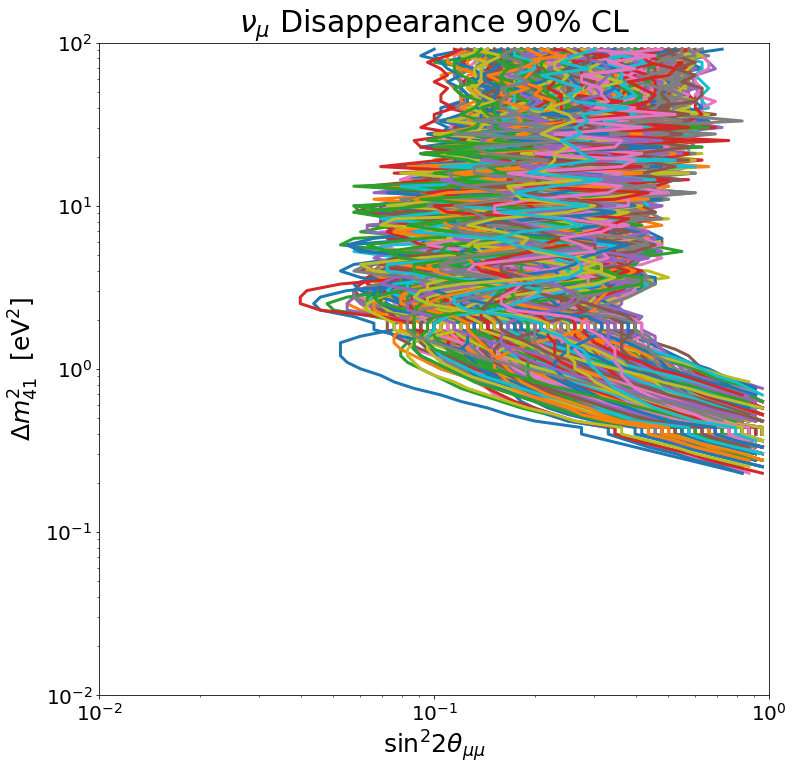

In [66]:
# 2DoF contours for all universes which reject the null

fig, ax = plt.subplots(figsize=(12,12))
msize=15

for i in range(1000):
    if not excluded[i]:
        continue
    tsin22th = sin22th_sr[f_chi2[i,:]>f_chi2.min(axis=1)[i]+4.61]
    tdm2 = dm2_sr[f_chi2[i]>f_chi2.min(axis=1)[i]+4.61]
    ln_90_sin22th,ln_90_dm2 = getContour(tsin22th,tdm2)
    plt.plot(ln_90_sin22th,ln_90_dm2,linewidth=3)

#plt.annotate('Frequentist Corrected',xy=(0.02, .28), xycoords='axes fraction',fontsize=35)
ax.set_title(r'$\nu_\mu$ Disappearance 90% CL',fontsize=30)
ax.legend(fontsize=30,frameon=False,loc='lower left')

plt.xlim(1e-2,1)
plt.ylim(0.01,100)
ax.set_ylabel(r'$\Delta m_{41}^2$  [eV$^2$]',fontsize=25)
ax.set_xlabel(r'$\sin^2 2 \theta_{\mu \mu}$',fontsize=25)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


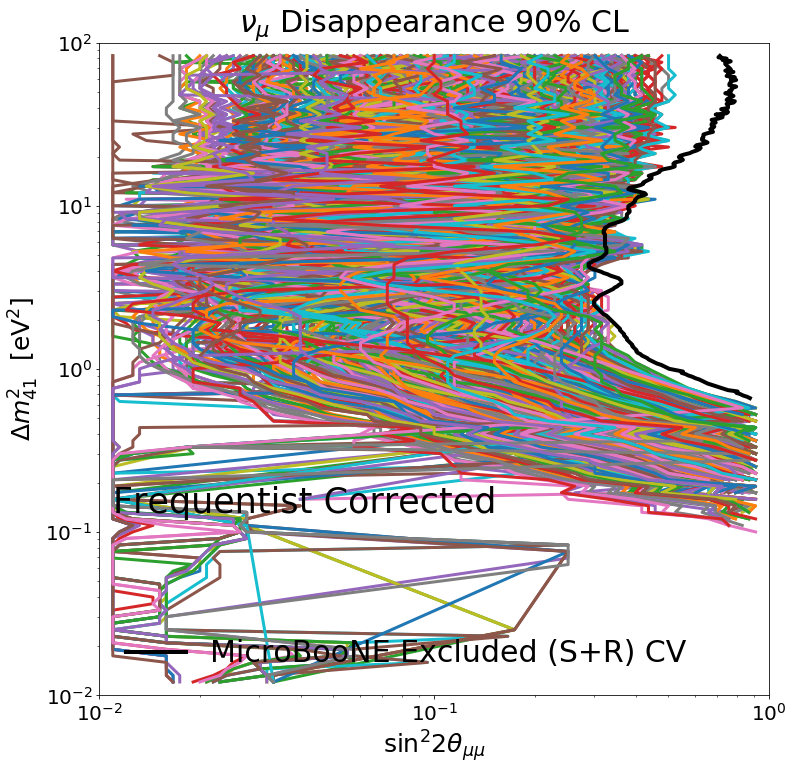

In [18]:
# Freq-corrected contours for all universes which reject the null

fig, ax = plt.subplots(figsize=(12,12))
msize=15

for i in range(1000):
    if not excluded[i]:
        continue
    tsin22th = sin22th_sr[f_chi2[i,:]>f_chi2.min(axis=1)[i]+g90_sr]
    tdm2 = dm2_sr[f_chi2[i]>f_chi2.min(axis=1)[i]+g90_sr]
    ln_90_sin22th,ln_90_dm2 = getContour(tsin22th,tdm2)
    plt.plot(ln_90_sin22th,ln_90_dm2,linewidth=3)

    
plt.plot(ln_90_sin22th_cv,ln_90_dm2_cv,linewidth=4,color='black',label='MicroBooNE Excluded (S+R) CV')

    
plt.annotate('Frequentist Corrected',xy=(0.02, .28), xycoords='axes fraction',fontsize=35)
ax.set_title(r'$\nu_\mu$ Disappearance 90% CL',fontsize=30)
ax.legend(fontsize=30,frameon=False,loc='lower left')



plt.xlim(1e-2,1)
plt.ylim(0.01,100)
ax.set_ylabel(r'$\Delta m_{41}^2$  [eV$^2$]',fontsize=25)
ax.set_xlabel(r'$\sin^2 2 \theta_{\mu \mu}$',fontsize=25)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

# Sensitivity sensitivity bands

In [14]:
v_sin22thPE = np.zeros((1000,100))

for expi in range(1000):
    if not excluded[expi]:
        continue
    tsin22th = sin22th_sr[f_chi2[expi,:]>f_chi2.min(axis=1)[expi]+g90_sr]
    tdm2 = dm2_sr[f_chi2[expi]>f_chi2.min(axis=1)[expi]+g90_sr]
    for mi,dm2 in enumerate(np.unique(dm2_sr)):
        if len(tsin22th[tdm2==dm2]) > 0:
            v_sin22thPE[expi][mi] = tsin22th[tdm2==dm2].min()
        else:
            v_sin22thPE[expi][mi] = 1.0

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [15]:
a_onesigmaleft = np.zeros(100)
a_onesigmaright = np.zeros(100)
a_cv = np.zeros(100)

mindex_onesigmaleft = int(np.floor((.16)*len(excluded[excluded==1])))
mindex_onesigmaright = int(np.floor((.84)*len(excluded[excluded==1])))

for mi,dm2 in enumerate(np.unique(dm2_sr)):
    a_cv[mi] = np.mean(v_sin22thPE[excluded==1][:,mi])
    a_onesigmaleft[mi] = np.partition(v_sin22thPE[excluded==1][:,mi],mindex_onesigmaleft)[mindex_onesigmaleft]
    a_onesigmaright[mi] = np.partition(v_sin22thPE[excluded==1][:,mi],mindex_onesigmaright)[mindex_onesigmaright]

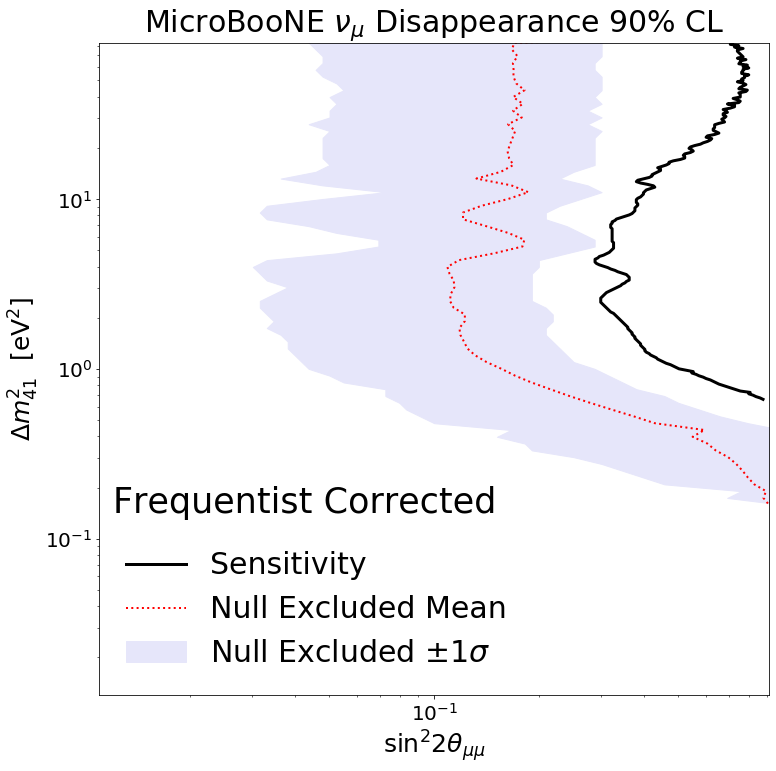

In [19]:
fig, ax = plt.subplots(figsize=(12,12))
msize=15

#plt.plot(a_onesigmaleft,np.unique(dm2_sr),linewidth=4,color='black',label='MicroBooNE Excluded (S+R) CV')

#plt.plot(a_onesigmaright,np.unique(dm2_sr),linewidth=4,color='black',label='MicroBooNE Excluded (S+R) CV')

plt.plot(ln_90_sin22th_cv,ln_90_dm2_cv,linewidth=3,color='black',label='Sensitivity')


plt.fill_betweenx(np.unique(dm2_sr),a_onesigmaleft,a_onesigmaright,color='lavender',label=r'Null Excluded $\pm1\sigma$')

plt.plot(a_cv,np.unique(dm2_sr),linewidth=2,color='red',linestyle=':',label='Null Excluded Mean')


plt.annotate('Frequentist Corrected',xy=(0.02, .28), xycoords='axes fraction',fontsize=35)
ax.set_title(r'MicroBooNE $\nu_\mu$ Disappearance 90% CL',fontsize=30)
ax.legend(fontsize=30,frameon=False,loc='lower left')

plt.xlim(a_sin22th_sr.min(),a_sin22th_sr.max())
plt.ylim(a_dm2_sr.min(),a_dm2_sr.max())
ax.set_ylabel(r'$\Delta m_{41}^2$  [eV$^2$]',fontsize=25)
ax.set_xlabel(r'$\sin^2 2 \theta_{\mu \mu}$',fontsize=25)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

In [21]:
chi2_sr = f_chi2[57]



ex_90_dm2_freq_sr = []
ex_90_sin22th_freq_sr = []

al_90_dm2_freq_sr = []
al_90_sin22th_freq_sr = []

chi2min_sr = chi2_sr.min() # sr
print(chi2min_sr)

for i,chisq in enumerate(chi2_sr):
    if chisq - chi2min_sr > g90_sr[i]:
        ex_90_dm2_freq_sr.append(dm2_sr[i])
        ex_90_sin22th_freq_sr.append(sin22th_sr[i])
    if chisq - chi2min_sr < g90_sr[i]:
        al_90_dm2_freq_sr.append(dm2_sr[i])
        al_90_sin22th_freq_sr.append(sin22th_sr[i])

15.7453


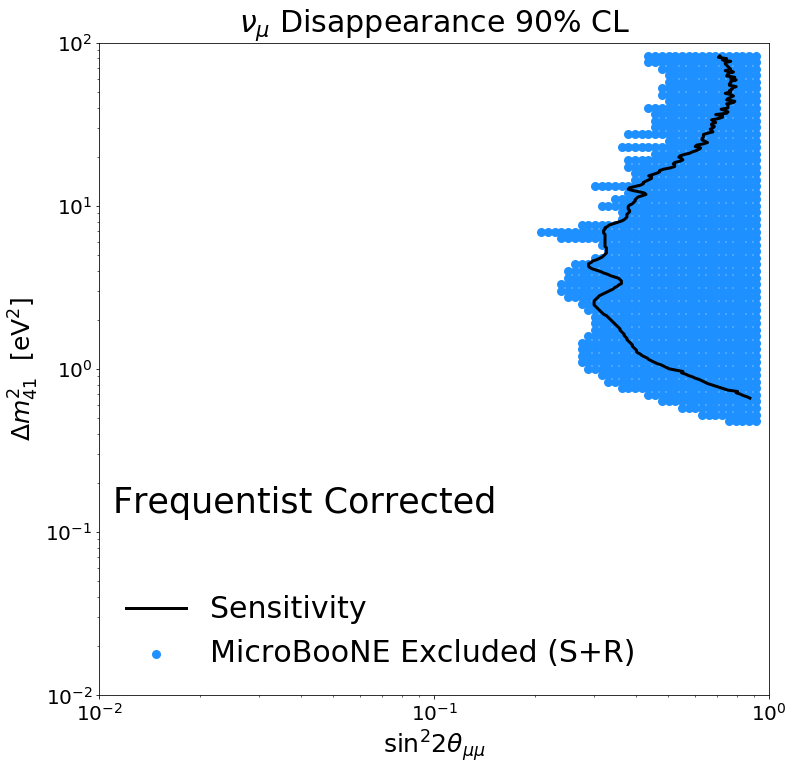

In [23]:
fig, ax = plt.subplots(figsize=(12,12))
msize=15

# mbnudis_90cl=np.genfromtxt("limits/mbnudis_90.csv",delimiter=',')
# refx = mbnudis_90cl[:,0]
# refy = mbnudis_90cl[:,1]
# plt.plot(refx[refy.argsort()],refy[refy.argsort()], color='black',  linestyle=":",linewidth=4,zorder=-1)
# plt.plot([0],[0],color='black',linestyle=':',linewidth=4,label='MiniBooNE Excluded  90% (SO)')


#ln_90_sin22th,lin_90_dm2 = getContour(ex_90_sin22th_freq_sr,ex_90_dm2_freq_sr)
#plt.plot(ln_90_sin22th,lin_90_dm2,linewidth=3,label='MicroBooNE Excluded (S+R)',c='dodgerblue')

plt.scatter(ex_90_sin22th_freq_sr,ex_90_dm2_freq_sr,linewidth=3,label='MicroBooNE Excluded (S+R)',c='dodgerblue')

plt.plot(ln_90_sin22th_cv,ln_90_dm2_cv,linewidth=3,color='black',label='Sensitivity')


plt.annotate('Frequentist Corrected',xy=(0.02, .28), xycoords='axes fraction',fontsize=35)
ax.set_title(r'$\nu_\mu$ Disappearance 90% CL',fontsize=30)
ax.legend(fontsize=30,frameon=False,loc='lower left')

plt.xlim(1e-2,1)
plt.ylim(0.01,100)
ax.set_ylabel(r'$\Delta m_{41}^2$  [eV$^2$]',fontsize=25)
ax.set_xlabel(r'$\sin^2 2 \theta_{\mu \mu}$',fontsize=25)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

array([0.136226, 3.35936 , 1.70949 , ..., 4.36172 , 5.84357 , 2.77006 ])

0.988011988011988
dof: 9.822540403788086


Text(0.15, 0.8, 'True Point allowed at 90%CL\nin 98.80% Pseudo-Experiments')

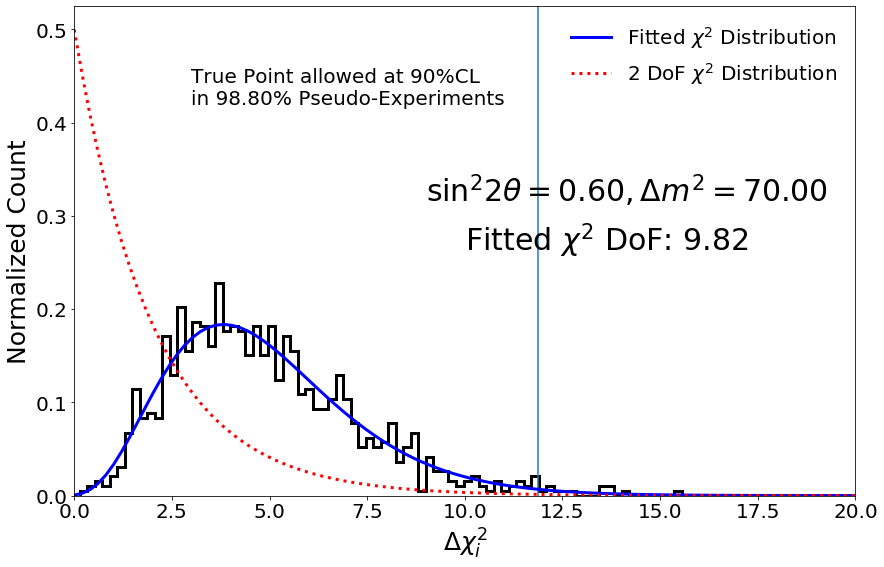

In [21]:
deltachisq = np.genfromtxt('../build/fakedata_deltachi_highdm2.txt')
fig,ax = plt.subplots(figsize=(14,9))


chic = 11.88
ax.axvline(11.88)
_ = plt.hist(deltachisq,histtype='step',bins=80,facecolor=None,linewidth=3,edgecolor='black',density=1)
s_full,_ = np.histogram(deltachisq,range=(0,20),bins=80)
s_frac,_ = np.histogram(deltachisq,range=(0,chic),bins=80)
print(s_frac.sum()/s_full.sum())


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax.set_xlim(0,20)
#ax.set_ylim(0,1)
x = np.linspace(.001,20,100)

ax.set_xlabel(r'$\Delta\chi^2_i$',fontsize=25)
ax.set_ylabel('Normalized Count',fontsize=25)

df,loc,scale = scipy.stats.distributions.chi2.fit(deltachisq)
fitted_data = scipy.stats.distributions.chi2.pdf(x,df,loc,scale)

twodof_data = scipy.stats.distributions.chi2.pdf(x,2,0,1)

print('dof:',df)

plt.plot(x,fitted_data,'b-',label=r'Fitted $\chi^2$ Distribution',linewidth=3)
plt.plot(x,twodof_data,'r:',label=r'2 DoF $\chi^2$ Distribution',linewidth=3)

ax.legend(fontsize=20,frameon=False)

plt.annotate(r'$\sin^22\theta=%.2f, \Delta m^2=%.2f$'%(0.6,70.0),xy=(0.45, .6), xycoords='axes fraction',fontsize=30)
plt.annotate(r'Fitted $\chi^2$ DoF: %.2f'%(df),xy=(0.5, .5), xycoords='axes fraction',fontsize=30)

plt.annotate(f'True Point allowed at 90%CL\nin {s_frac.sum()/s_full.sum()*100.0:.2f}% Pseudo-Experiments',xy=(0.15, .8), xycoords='axes fraction',fontsize=20)


#ax.set_title('@ Best Fit',fontsize=40)

0.9180819180819181
dof: 9.485927166337452


Text(0.15, 0.8, 'True Point allowed at 90%CL\nin 91.81% Pseudo-Experiments')

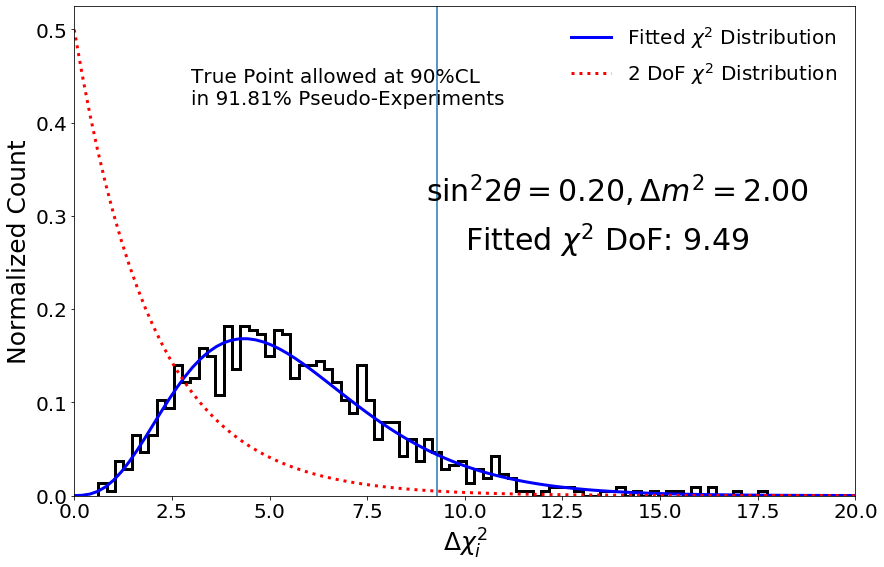

In [24]:
deltachisq = np.genfromtxt('../build/fakedata_deltachi_middm2_freq.txt')
fig,ax = plt.subplots(figsize=(14,9))


chic = 9.28002954
ax.axvline(chic)
_ = plt.hist(deltachisq,histtype='step',bins=80,facecolor=None,linewidth=3,edgecolor='black',density=1)
s_full,_ = np.histogram(deltachisq,range=(0,20),bins=80)
s_frac,_ = np.histogram(deltachisq,range=(0,chic),bins=80)
print(s_frac.sum()/s_full.sum())


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax.set_xlim(0,20)
#ax.set_ylim(0,1)
x = np.linspace(.001,20,100)

ax.set_xlabel(r'$\Delta\chi^2_i$',fontsize=25)
ax.set_ylabel('Normalized Count',fontsize=25)

df,loc,scale = scipy.stats.distributions.chi2.fit(deltachisq)
fitted_data = scipy.stats.distributions.chi2.pdf(x,df,loc,scale)

twodof_data = scipy.stats.distributions.chi2.pdf(x,2,0,1)

print('dof:',df)

plt.plot(x,fitted_data,'b-',label=r'Fitted $\chi^2$ Distribution',linewidth=3)
plt.plot(x,twodof_data,'r:',label=r'2 DoF $\chi^2$ Distribution',linewidth=3)

ax.legend(fontsize=20,frameon=False)

plt.annotate(r'$\sin^22\theta=%.2f, \Delta m^2=%.2f$'%(0.2,2),xy=(0.45, .6), xycoords='axes fraction',fontsize=30)
plt.annotate(r'Fitted $\chi^2$ DoF: %.2f'%(df),xy=(0.5, .5), xycoords='axes fraction',fontsize=30)

plt.annotate(f'True Point allowed at 90%CL\nin {s_frac.sum()/s_full.sum()*100.0:.2f}% Pseudo-Experiments',xy=(0.15, .8), xycoords='axes fraction',fontsize=20)


#ax.set_title('@ Best Fit',fontsize=40)

0.7985537190082644
dof: 10.587791031863024


Text(0.15, 0.8, 'True Point allowed at 90%CL\nin 79.86% Pseudo-Experiments')

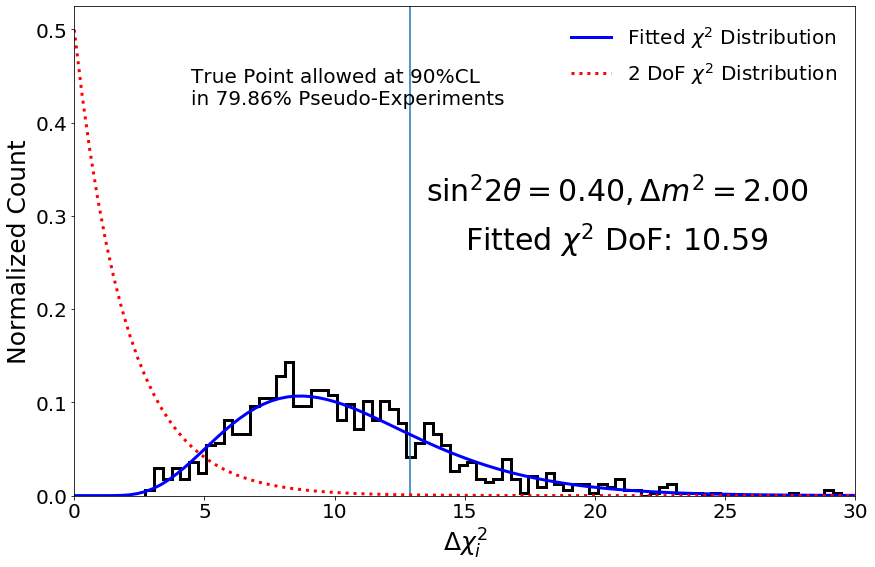

In [20]:
deltachisq = np.genfromtxt('../build/fakedata_deltachi_s04_d2.txt')
fig,ax = plt.subplots(figsize=(14,9))


chic = 12.87951387
ax.axvline(chic)
_ = plt.hist(deltachisq,histtype='step',bins=80,facecolor=None,linewidth=3,edgecolor='black',density=1)
s_full,_ = np.histogram(deltachisq,range=(0,20),bins=80)
s_frac,_ = np.histogram(deltachisq,range=(0,chic),bins=80)
print(s_frac.sum()/s_full.sum())


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax.set_xlim(0,30)
#ax.set_ylim(0,1)
x = np.linspace(.001,30,100)

ax.set_xlabel(r'$\Delta\chi^2_i$',fontsize=25)
ax.set_ylabel('Normalized Count',fontsize=25)

df,loc,scale = scipy.stats.distributions.chi2.fit(deltachisq)
fitted_data = scipy.stats.distributions.chi2.pdf(x,df,loc,scale)

twodof_data = scipy.stats.distributions.chi2.pdf(x,2,0,1)

print('dof:',df)

plt.plot(x,fitted_data,'b-',label=r'Fitted $\chi^2$ Distribution',linewidth=3)
plt.plot(x,twodof_data,'r:',label=r'2 DoF $\chi^2$ Distribution',linewidth=3)

ax.legend(fontsize=20,frameon=False)

plt.annotate(r'$\sin^22\theta=%.2f, \Delta m^2=%.2f$'%(0.4,2.0),xy=(0.45, .6), xycoords='axes fraction',fontsize=30)
plt.annotate(r'Fitted $\chi^2$ DoF: %.2f'%(df),xy=(0.5, .5), xycoords='axes fraction',fontsize=30)

plt.annotate(f'True Point allowed at 90%CL\nin {s_frac.sum()/s_full.sum()*100.0:.2f}% Pseudo-Experiments',xy=(0.15, .8), xycoords='axes fraction',fontsize=20)


#ax.set_title('@ Best Fit',fontsize=40)

0.985
dof: 8.164643660070745


Text(0.15, 0.8, 'True Point allowed at 90%CL\nin 98.50% Pseudo-Experiments')

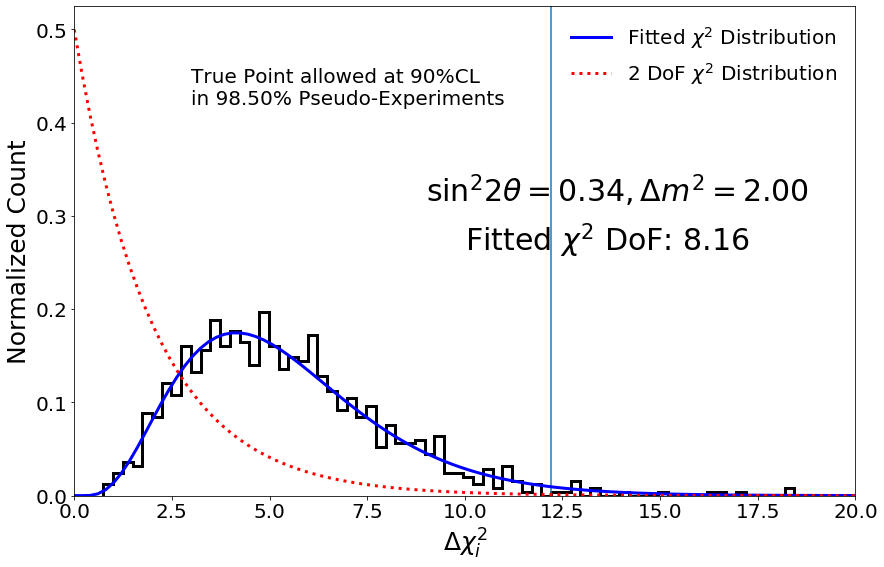

In [27]:
deltachisq = np.genfromtxt('../build/fakedata_chi2_s034_d2.txt')
fig,ax = plt.subplots(figsize=(14,9))


chic = 12.19508541
ax.axvline(chic)
_ = plt.hist(deltachisq,histtype='step',bins=80,facecolor=None,linewidth=3,edgecolor='black',density=1)
s_full,_ = np.histogram(deltachisq,range=(0,20),bins=80)
s_frac,_ = np.histogram(deltachisq,range=(0,chic),bins=80)
print(s_frac.sum()/s_full.sum())


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


ax.set_xlim(0,20)
#ax.set_ylim(0,1)
x = np.linspace(.001,20,100)

ax.set_xlabel(r'$\Delta\chi^2_i$',fontsize=25)
ax.set_ylabel('Normalized Count',fontsize=25)

df,loc,scale = scipy.stats.distributions.chi2.fit(deltachisq)
fitted_data = scipy.stats.distributions.chi2.pdf(x,df,loc,scale)

twodof_data = scipy.stats.distributions.chi2.pdf(x,2,0,1)

print('dof:',df)

plt.plot(x,fitted_data,'b-',label=r'Fitted $\chi^2$ Distribution',linewidth=3)
plt.plot(x,twodof_data,'r:',label=r'2 DoF $\chi^2$ Distribution',linewidth=3)

ax.legend(fontsize=20,frameon=False)

plt.annotate(r'$\sin^22\theta=%.2f, \Delta m^2=%.2f$'%(0.34,2),xy=(0.45, .6), xycoords='axes fraction',fontsize=30)
plt.annotate(r'Fitted $\chi^2$ DoF: %.2f'%(df),xy=(0.5, .5), xycoords='axes fraction',fontsize=30)

plt.annotate(f'True Point allowed at 90%CL\nin {s_frac.sum()/s_full.sum()*100.0:.2f}% Pseudo-Experiments',xy=(0.15, .8), xycoords='axes fraction',fontsize=20)


#ax.set_title('@ Best Fit',fontsize=40)